<a href="https://colab.research.google.com/github/YASSIRAMRAOUI/Text-Mining/blob/main/Atelier_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atelier 5 — Topic Modeling

Ce notebook fournit :

1. Une **visualisation globale** des topics découverts par **LSA** (SVD sur TF-IDF) et **LDA** (sur matrice de comptes).
2. Une implémentation simple d'un **modèle Unigramme** pour **découvrir un "topic" par document** (on prend les mots les plus probables du document).
3. Des cellules **commentées** et un style de rapport pédagogique (explications + commandes).

> Remplacez les parties `CHARGER VOS DONNÉES` par vos propres fichiers/données si vous voulez réutiliser ce notebook sur votre jeu de données.

In [29]:
# Imports et fonctions utilitaires
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

# Fonction : afficher les mots-clés d'un topic

def print_top_words(model, feature_names, n_top_words=10):
    """Affiche les top mots pour chaque topic du modèle (LSA ou LDA)."""
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        print("Topic #%d: %s" % (topic_idx+1, ", ".join(top_words)))
    print()

# Fonction : tracer les top mots (bar chart) pour chaque topic

def plot_top_words_bar(model, feature_names, n_top_words=10, title_prefix="Topic"):
    """Génère un plot par topic (bar chart) des poids des mots."""
    n_topics = model.components_.shape[0]
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        top_values = topic[top_indices]
        plt.figure(figsize=(8,4))
        plt.bar(range(len(top_words)), top_values)
        plt.xticks(range(len(top_words)), top_words, rotation=45, ha='right')
        plt.title(f"{title_prefix} {topic_idx+1}")
        plt.tight_layout()
        plt.show()


## Chargement des données

Par défaut ce notebook charge le jeu de données **20 newsgroups** (pratique pour tester).

**Si vous avez déjà un fichier de documents** (par ex. `documents.csv` contenant une colonne `text`) :
1. Remplacez la cellule ci-dessous pour charger votre CSV (pandas.read_csv).
2. Assurez-vous que la colonne texte s'appelle `text` ou ajustez le code.

Le code charge les 2000 premiers documents pour accélérer les calculs (modifiable).

In [30]:
# CHARGER VOS DONNÉES: par défaut on utilise sklearn.datasets.fetch_20newsgroups
from sklearn.datasets import fetch_20newsgroups

print("Chargement du dataset 20 newsgroups (subset 'all') — utilisez vos propres données si besoin...")
data = fetch_20newsgroups(subset='all', remove=('headers','footers','quotes'))
documents = list(data.data)
targets = data.target if hasattr(data, 'target') else None

# Limiter le nombre de documents pour rapidité (optionnel)
MAX_DOCS = 2000
documents = documents[:MAX_DOCS]
if targets is not None:
    targets = targets[:MAX_DOCS]

print(f"Nombre de documents chargés: {len(documents)}")


Chargement du dataset 20 newsgroups (subset 'all') — utilisez vos propres données si besoin...
Nombre de documents chargés: 2000


## Prétraitement et Vectorisation

- Nous allons construire deux représentations :
  - **TF-IDF** (pour LSA / TruncatedSVD)
  - **Count (comptes)** (pour LDA)
- Le module `sklearn.feature_extraction.text` fournit `TfidfVectorizer` et `CountVectorizer`.

In [31]:
# Vectorisation (TF-IDF pour LSA, Count pour LDA)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english', ngram_range=(1,1))
count_vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english', ngram_range=(1,1))

tfidf = tfidf_vectorizer.fit_transform(documents)
counts = count_vectorizer.fit_transform(documents)

print('TF-IDF shape:', tfidf.shape)
print('Count matrix shape:', counts.shape)


TF-IDF shape: (2000, 4874)
Count matrix shape: (2000, 4874)


## LSA (Latent Semantic Analysis) — Truncated SVD sur TF-IDF

- Nous appliquons une décomposition SVD pour extraire les topics (composantes latentes).
- On affiche les top mots de chaque topic et on trace une projection globale des documents selon les composantes principales.

Top mots LSA:
Topic #1: like, just, don, know, people, think, does, time, use, good, god, way
Topic #2: god, people, jesus, say, bible, think, believe, don, did, said, law, christ
Topic #3: god, jesus, bible, does, christ, windows, christians, sin, believe, card, christian, church
Topic #4: drive, scsi, controller, bus, card, disk, hard, drives, ide, speed, god, external
Topic #5: edu, drive, com, address, mail, list, reply, university, send, email, information, cs
Topic #6: drive, file, files, program, dos, disk, use, key, hard, government, window, people
Topic #7: know, thanks, drive, like, just, window, don, think, game, windows, bike, anybody
Topic #8: game, year, 00, god, jesus, file, games, team, dos, 10, win, files



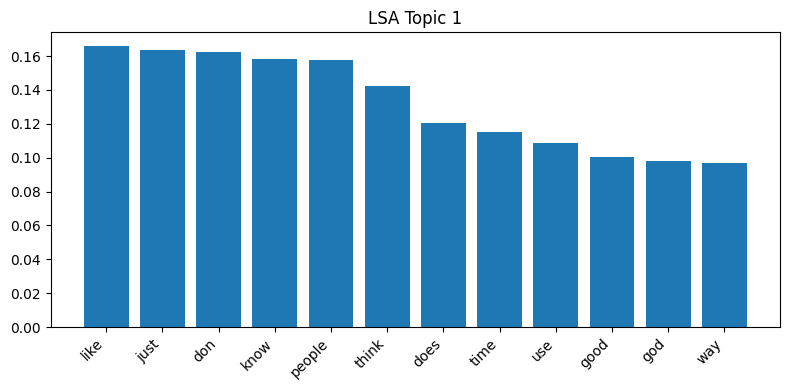

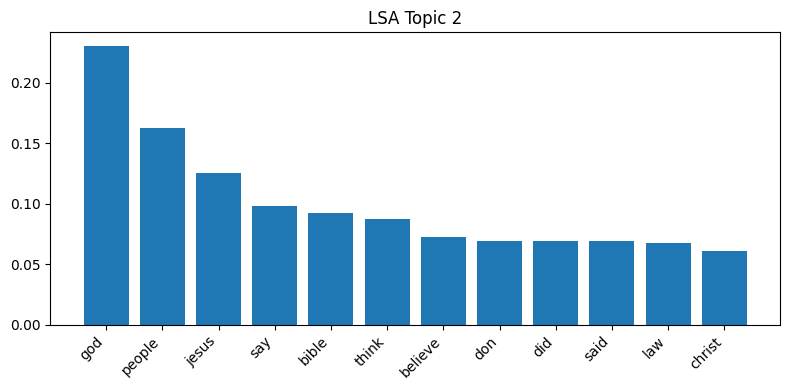

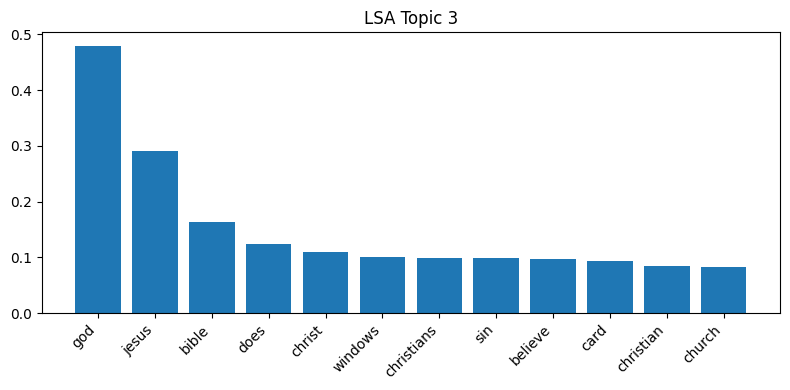

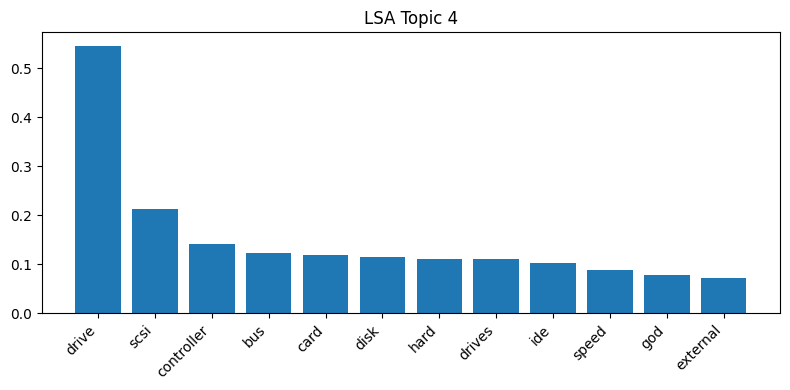

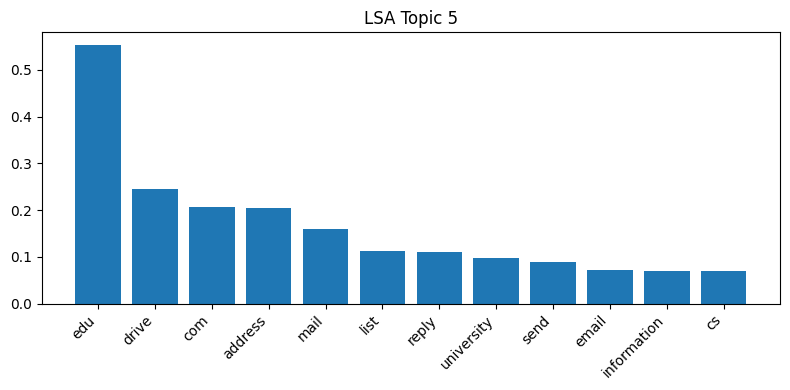

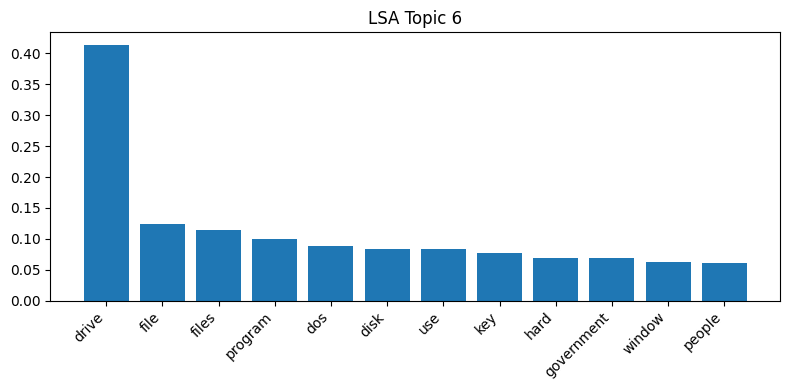

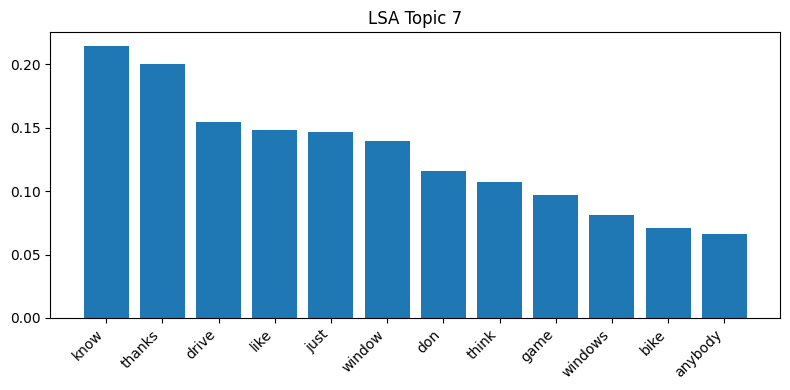

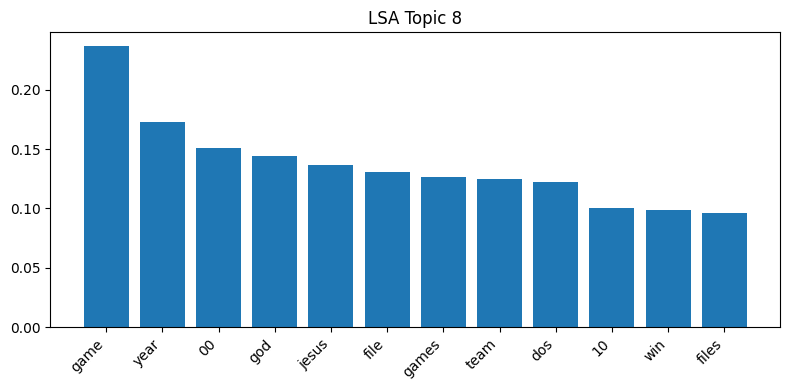

In [32]:
# Paramètres LSA
n_topics_lsa = 8  # ajustez selon vos besoins

lsa = TruncatedSVD(n_components=n_topics_lsa, random_state=42)
lsa_topic_matrix = lsa.fit_transform(tfidf)  # matrice documents x topics (scores)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

print('Top mots LSA:')
print_top_words(lsa, feature_names_tfidf, n_top_words=12)

# Visualisation: bar charts des top mots pour chaque topic LSA
plot_top_words_bar(lsa, feature_names_tfidf, n_top_words=12, title_prefix='LSA Topic')


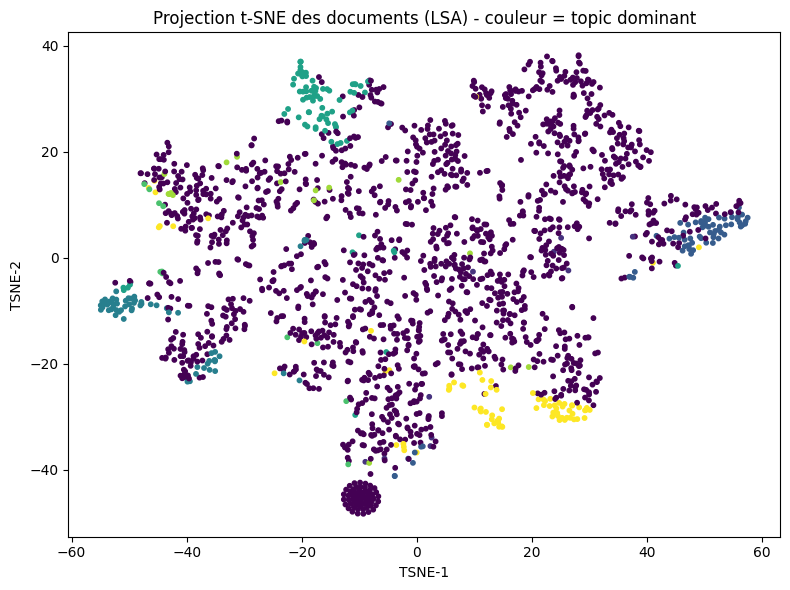

In [33]:
# Visualisation globale: projection t-SNE des documents en utilisant la matrice topic (LSA)
# On colore chaque point par le topic dominant (composante la plus élevée)
doc_topics_lsa = np.argmax(lsa_topic_matrix, axis=1)

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
doc_emb_2d = tsne.fit_transform(lsa_topic_matrix)

plt.figure(figsize=(8,6))
plt.scatter(doc_emb_2d[:,0], doc_emb_2d[:,1], s=10, c=doc_topics_lsa)
plt.title('Projection t-SNE des documents (LSA) - couleur = topic dominant')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.tight_layout()
plt.show()


## LDA (Latent Dirichlet Allocation)

- LDA est un modèle génératif qui apprend une distribution de topics pour chaque document et une distribution de mots pour chaque topic.
- Nous utilisons la matrice de comptes (`CountVectorizer`) et `sklearn.decomposition.LatentDirichletAllocation`.

Top mots LDA:
Topic #1: car, 000, bike, cars, insurance, speed, xterm, sci, power, miles, oil, define
Topic #2: window, use, 00, like, ve, just, dos, start, know, time, work, water
Topic #3: ed, 00, 10, 11, game, 15, 17, 30, 12, year, 20, 34
Topic #4: space, president, armenian, new, station, united, government, research, science, university, states, washington
Topic #5: people, don, think, like, just, know, time, god, say, way, does, right
Topic #6: thanks, drive, problem, know, new, does, memory, old, using, got, try, mail
Topic #7: jpeg, file, use, image, gif, files, bit, software, windows, data, version, images
Topic #8: edu, com, mail, list, cs, address, internet, information, uk, ca, email, john



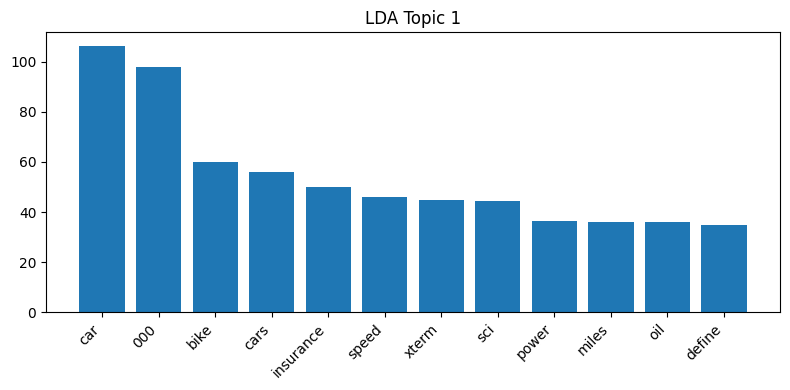

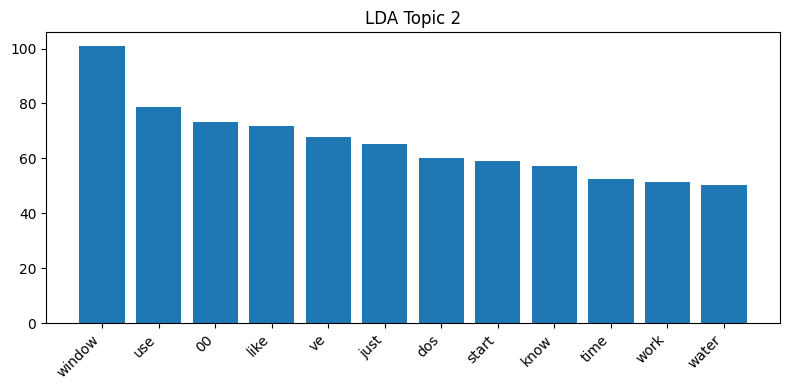

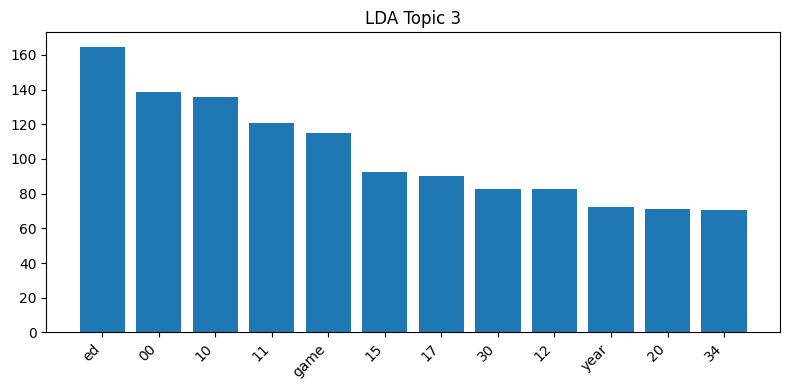

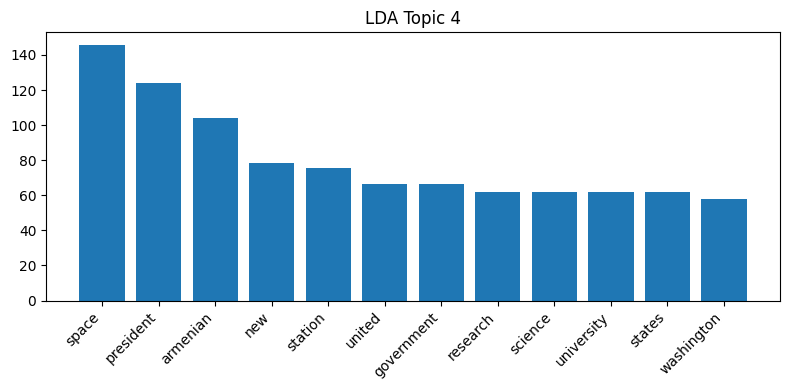

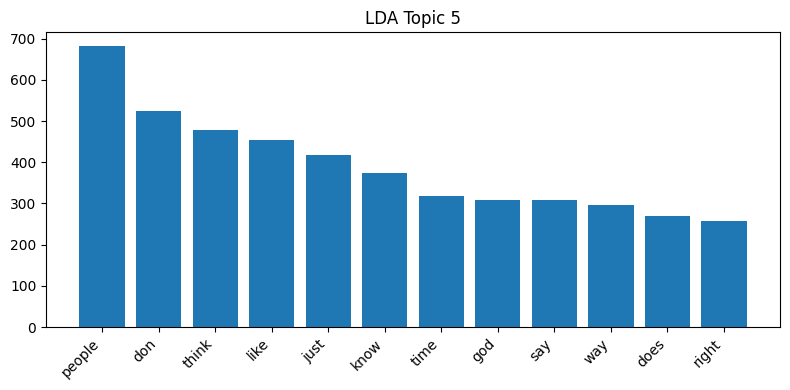

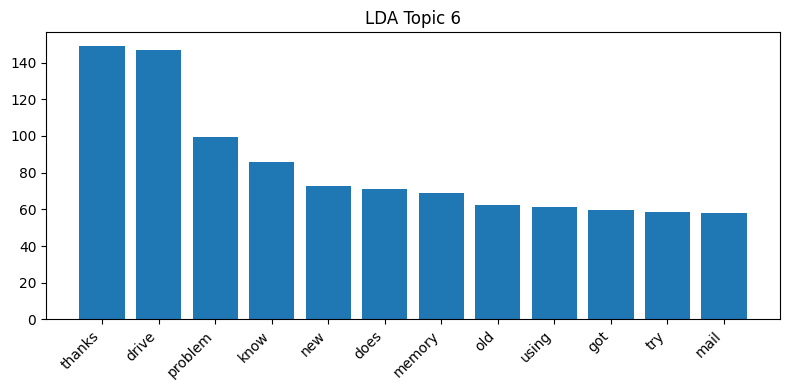

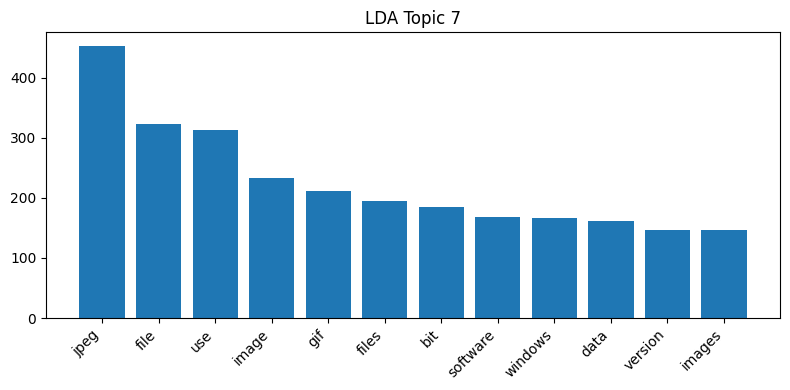

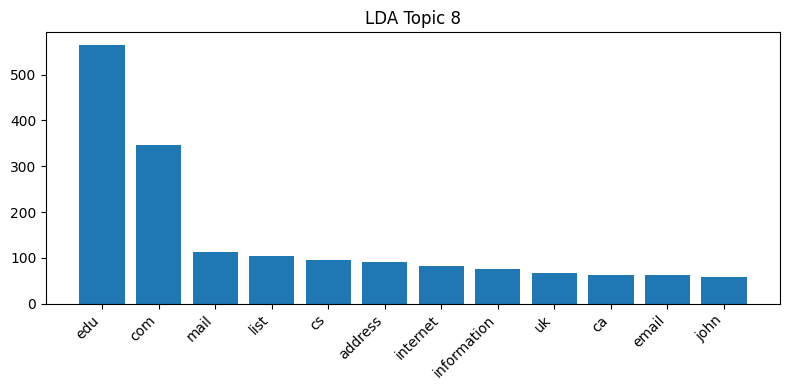

In [34]:
# Paramètres LDA
n_topics_lda = 8  # ajustez selon vos besoins
lda = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=10, learning_method='online', random_state=0)
lda_topic_matrix = lda.fit_transform(counts)  # matrice documents x topics (probabilités)
feature_names_count = count_vectorizer.get_feature_names_out()

print('Top mots LDA:')
print_top_words(lda, feature_names_count, n_top_words=12)

# Visualisation: bar charts des top mots pour chaque topic LDA
plot_top_words_bar(lda, feature_names_count, n_top_words=12, title_prefix='LDA Topic')


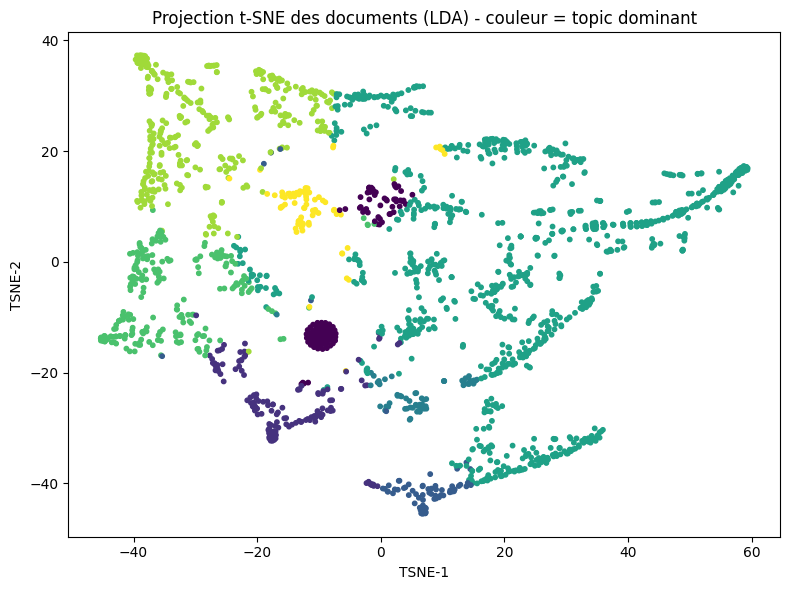

In [35]:
# Visualisation globale: projection t-SNE des documents en utilisant la matrice topic (LDA)
doc_topics_lda = np.argmax(lda_topic_matrix, axis=1)

tsne_lda = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
doc_emb_2d_lda = tsne_lda.fit_transform(lda_topic_matrix)

plt.figure(figsize=(8,6))
plt.scatter(doc_emb_2d_lda[:,0], doc_emb_2d_lda[:,1], s=10, c=doc_topics_lda)
plt.title('Projection t-SNE des documents (LDA) - couleur = topic dominant')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.tight_layout()
plt.show()


## Comparaison LSA vs LDA (résumé visuel)

- Les deux projections (LSA et LDA) permettent d'observer la séparation (ou le chevauchement) des documents par topic dominant.
- Comparez les top mots affichés plus haut pour juger si les topics sont cohérents.

In [36]:
# Tableau résumé: pour chaque document, topic dominant LSA / LDA et les 5 mots les plus fréquents du document
from sklearn.feature_extraction.text import CountVectorizer as CV_local
cv_local = CV_local(stop_words='english', min_df=1)
dt_counts = cv_local.fit_transform(documents)
vocab_local = cv_local.get_feature_names_out()

def top_words_of_doc(doc, n=5):
    tokens = doc.split()
    vec = cv_local.transform([doc]).toarray()[0]
    top_idx = vec.argsort()[::-1][:n]
    return [vocab_local[i] for i in top_idx if vec[i]>0]

summary = []
for i, doc in enumerate(documents[:200]):  # limiter pour lisibilité
    summary.append({
        'doc_id': i,
        'lsa_topic': int(doc_topics_lsa[i]),
        'lda_topic': int(doc_topics_lda[i]),
        'top_words_doc': ', '.join(top_words_of_doc(doc, n=5))
    })

df_summary = pd.DataFrame(summary)
df_summary.head(20)


,doc_id,lsa_topic,lda_topic,top_words_doc
0,0,0,4,"pens, bit, season, fun, regular"
1,1,0,6,"card, bus, high, pro, local"
2,2,0,4,"weapons, armenians, azerbadjan, true, fight"
3,3,3,6,"data, bus, scsi, transfers, devices"
4,4,3,5,"drive, use, inexpensive, tape, jasmine"
5,5,0,4,"type, perception, visual, high, school"
6,6,0,6,"214, 241, try, 6060, 0055"
7,7,7,1,"00, abc, buff, games, did"
8,8,0,1,"good, look, trying, price, didn"
9,9,2,4,"turkey, christmas, truelove, served, day"


## Modèle Unigramme — Découvrir un *topic* par document

Approche simple et interprétable : pour chaque document, on construit son **modèle unigramme** (fréquence relative des mots dans le doc) et on **choisit les top-k mots** du document comme son "topic".

- C'est une méthode basique (non probabiliste multi-documents) mais utile comme baseline.
- Vous pouvez améliorer : utiliser LLR, KL-divergence par rapport au corpus, ou classer mots par surprisal.

In [37]:
# Pour chaque document, calculer la distribution unigramme et extraire les mots les plus probables
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sk_stopwords

def unigram_topic_for_doc(doc, n_top=5, stopwords=set(sk_stopwords)):
    tokens = [t.lower().strip(".,!?;:\\'\"()[]") for t in doc.split() if t.strip()!='']
    tokens = [t for t in tokens if t.isalpha() and len(tokens)>1 and t not in stopwords]
    if len(tokens)==0:
        return []
    freqs = {}
    for t in tokens:
        freqs[t] = freqs.get(t, 0) + 1
    top = sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:n_top]
    return [w for w,c in top]

unigram_topics = [unigram_topic_for_doc(doc, n_top=5) for doc in documents]

# Exemple: afficher 10 documents + leur topic unigramme
for i in range(10):
    print(f"Doc {i} - Top unigram words: {unigram_topics[i]}")

Doc 0 - Top unigram words: ['pens', 'bit', 'devils', 'going', 'jagr']
Doc 1 - Top unigram words: ['card', 'local', 'bus', 'pro', 'brother']
Doc 2 - Top unigram words: ['weapons', 'armenians', 'azerbadjan', 'like', 'true']
Doc 3 - Top unigram words: ['data', 'bus', 'scsi', 'transfers', 'devices']
Doc 4 - Top unigram words: ['drive', 'use', 'jasmine', 'know', 'inexpensive']
Doc 5 - Top unigram words: ['high', 'school', 'worked', 'lab', 'assistant']
Doc 6 - Top unigram words: ['ae', 'tech', 'support', 'line', 'started']
Doc 7 - Top unigram words: ['watch', 'abc', 'cbc', 'hockey', 'did']
Doc 8 - Top unigram words: ['good', 'look', 'yeah', 'second', 'believe']
Doc 9 - Top unigram words: ['turkey', 'christian', 'jesus', 'day', 'christmas']


In [38]:
# Pour chaque document, calculer la distribution unigramme et extraire les mots les plus probables
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sk_stopwords

def unigram_topic_for_doc(doc, n_top=5, stopwords=set(sk_stopwords)):
    tokens = [t.lower().strip(".,!?;:\\'\"()[]") for t in doc.split() if t.strip()!='']
    tokens = [t for t in tokens if t.isalpha() and len(t)>1 and t not in stopwords]
    if len(tokens)==0:
        return []
    freqs = {}
    for t in tokens:
        freqs[t] = freqs.get(t, 0) + 1
    top = sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:n_top]
    return [w for w,c in top]

unigram_topics = [unigram_topic_for_doc(doc, n_top=5) for doc in documents]

# Exemple: afficher 10 documents + leur topic unigramme
for i in range(10):
    print(f"Doc {i} - Top unigram words: {unigram_topics[i]}")

Doc 0 - Top unigram words: ['pens', 'bit', 'devils', 'going', 'jagr']
Doc 1 - Top unigram words: ['card', 'local', 'bus', 'pro', 'brother']
Doc 2 - Top unigram words: ['weapons', 'armenians', 'azerbadjan', 'like', 'true']
Doc 3 - Top unigram words: ['data', 'bus', 'scsi', 'transfers', 'devices']
Doc 4 - Top unigram words: ['drive', 'use', 'jasmine', 'know', 'inexpensive']
Doc 5 - Top unigram words: ['high', 'school', 'worked', 'lab', 'assistant']
Doc 6 - Top unigram words: ['ae', 'tech', 'support', 'line', 'started']
Doc 7 - Top unigram words: ['watch', 'abc', 'cbc', 'hockey', 'did']
Doc 8 - Top unigram words: ['good', 'look', 'yeah', 'second', 'believe']
Doc 9 - Top unigram words: ['turkey', 'christian', 'jesus', 'day', 'christmas']
